Kohl Reddy
<br>
Spotify song recommendation analysis

##**Libraries And Dataset**

In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(formatter={'float_kind':"{:3.2f}".format})

import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, balanced_accuracy_score, confusion_matrix, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import seaborn as sns
import plotly.graph_objects as go

In [ ]:
#load in the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = '/content/drive/MyDrive/spotifydataset.csv'
df = pd.read_csv(filepath)
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.451,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.206,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.992,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.431,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.145,0.000000,0.0753,0.6470,155.117,179413,4,1


#**Data Description**

This dataset is list of unnamed songs collected using a web-crawler on the Spotify API. The 200 songs are qualified based on 12-number-valued features and one catergorically-valued feature (mode), and whether the song was liked (which is the target of the dataset). The aim of the dataset is to train a model to recommend songs to the user based on their prefrences.  


This dataset was found on Kaggle (https://www.kaggle.com/datasets/bricevergnou/spotify-recommendation). It was published and created by Brice Vergnou to help curate song recommendations.

Features:
<br>
*   **Danceability** - how suitable the song is for dancing (using musical elements such as tempo). On scale from 0 (least dancible) to 1 (most dancible).
*   **Energy** - the intensity and activity of the music. On a scale from 0 (least energy) to 1 (most energy).
* **Key**- the key the music is played in. There are 18 different keys used in the range of songs chosen. There are 24 possible keys for any song.
* **Loudness**- the loudness of music measured in decibels (dB). The lowest decibel found in the dataset is -42.26 and the highest decibel -2.33. Values typical range between -60dB and 0 dB.
* **Mode** - valued 0 (minor) and 1 (major); indicates the modality of a track.
* **Speechiness**- the amount of time during which words are actively spoken on the track. Data ranges from 2% to 54% of the song having spoken words.
* **acousticness** - A measure of the organicness of the track. Valued from 0 (low acousticness) to 1 (high acousticness).
* **instrumentalness**- valued from 0 (yes vocals) to 1 (no vocals).
* **liveness** - presence of a audience in a recording. Valued from 0 (no audience) to 1 (yes loud audience).
* **valence** - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. 0 represents musical negativeness, 1 represents musical positiveness.
* **tempo**- The overall estimated tempo of a track in beats per minute (BPM) from 60bpm to 180 bpm.
* **duration**- the duraion of the song (originally in milliseconds).
* **time signature**- the time signature of the song, recorded in beats per measure. Fractional value between 1 and 5.


Target:
<br>
* **liked**- valued 1 for liked songs, 0 for disliked songs.


This dataset is a classification dataset. The class values will be either liked (1) or disliked (0).

#**Perform Data Cleaning and Preprocessing**

In [ ]:
#check for missing values
df.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
liked               0
dtype: int64

The dataset contains no missing values.

In [ ]:
df.describe() #describing simple dataset statistics

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.636656,0.638431,5.497436,-9.481631,0.538462,0.148957,0.319093,0.192337,0.148455,0.493632,121.086174,213408.933333,3.912821,0.512821
std,0.216614,0.260096,3.415209,6.525086,0.499802,0.120414,0.320782,0.346226,0.105975,0.267695,28.084829,72152.392864,0.451332,0.501122
min,0.130000,0.002400,0.000000,-42.261000,0.000000,0.027800,0.000003,0.000000,0.033100,0.035300,60.171000,77203.000000,1.000000,0.000000
25%,0.462500,0.533500,2.000000,-9.962000,0.000000,0.056800,0.042200,0.000000,0.084000,0.269000,100.242000,178300.500000,4.000000,0.000000
50%,0.705000,0.659000,6.000000,-7.766000,1.000000,0.096200,0.213000,0.000008,0.105000,0.525000,124.896000,204000.000000,4.000000,1.000000
75%,0.799000,0.837500,8.000000,-5.829000,1.000000,0.230500,0.504000,0.097500,0.177000,0.717500,142.460500,242373.500000,4.000000,1.000000
max,0.946000,0.996000,11.000000,-2.336000,1.000000,0.540000,0.995000,0.969000,0.633000,0.980000,180.036000,655213.000000,5.000000,1.000000


In [ ]:
df.dtypes #checking homogeneity of data

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
liked                 int64
dtype: object

In [ ]:
df['liked'] = df['liked'].replace(1, 'yes') #making class labels more comprehensible
df['liked'] = df['liked'].replace(0, 'no')

In [ ]:
df.rename(columns={'duration_ms':'duration_s'}, inplace=True) #scaling the duration column and renaming it to reflect the change
df['duration_s'] = df['duration_s'].apply(lambda x: x/1000)


# **Perform Preliminary Data Analysis:**

In [ ]:
#shape of data set: rows, columns
df.shape

(195, 14)

This dataset has 195 rows and 14 columns.

In [ ]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.636656,0.638431,5.497436,-9.481631,0.538462,0.148957,0.319093,0.192337,0.148455,0.493632,121.086174,213.408933,3.912821
std,0.216614,0.260096,3.415209,6.525086,0.499802,0.120414,0.320782,0.346226,0.105975,0.267695,28.084829,72.152393,0.451332
min,0.130000,0.002400,0.000000,-42.261000,0.000000,0.027800,0.000003,0.000000,0.033100,0.035300,60.171000,77.203000,1.000000
25%,0.462500,0.533500,2.000000,-9.962000,0.000000,0.056800,0.042200,0.000000,0.084000,0.269000,100.242000,178.300500,4.000000
50%,0.705000,0.659000,6.000000,-7.766000,1.000000,0.096200,0.213000,0.000008,0.105000,0.525000,124.896000,204.000000,4.000000
75%,0.799000,0.837500,8.000000,-5.829000,1.000000,0.230500,0.504000,0.097500,0.177000,0.717500,142.460500,242.373500,4.000000
max,0.946000,0.996000,11.000000,-2.336000,1.000000,0.540000,0.995000,0.969000,0.633000,0.980000,180.036000,655.213000,5.000000


# **Perform Exploratory Analysis by use of Visualization**

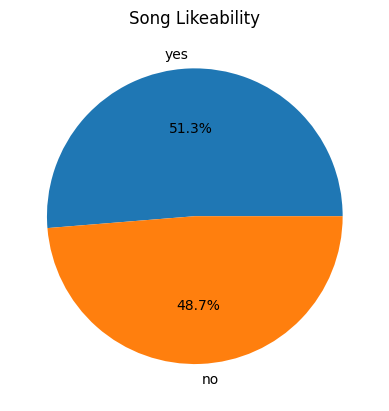

In [ ]:
#Pie Chart of the data
quality_counts = df['liked'].value_counts()

plt.pie(quality_counts, labels=quality_counts.index, autopct='%1.1f%%')
plt.title('Song Likeability')
plt.show()

From this graphic we can see there is a comfortably balanced distribution between liked and disliked songs, which all but eliminates the possibility of bias in our data.

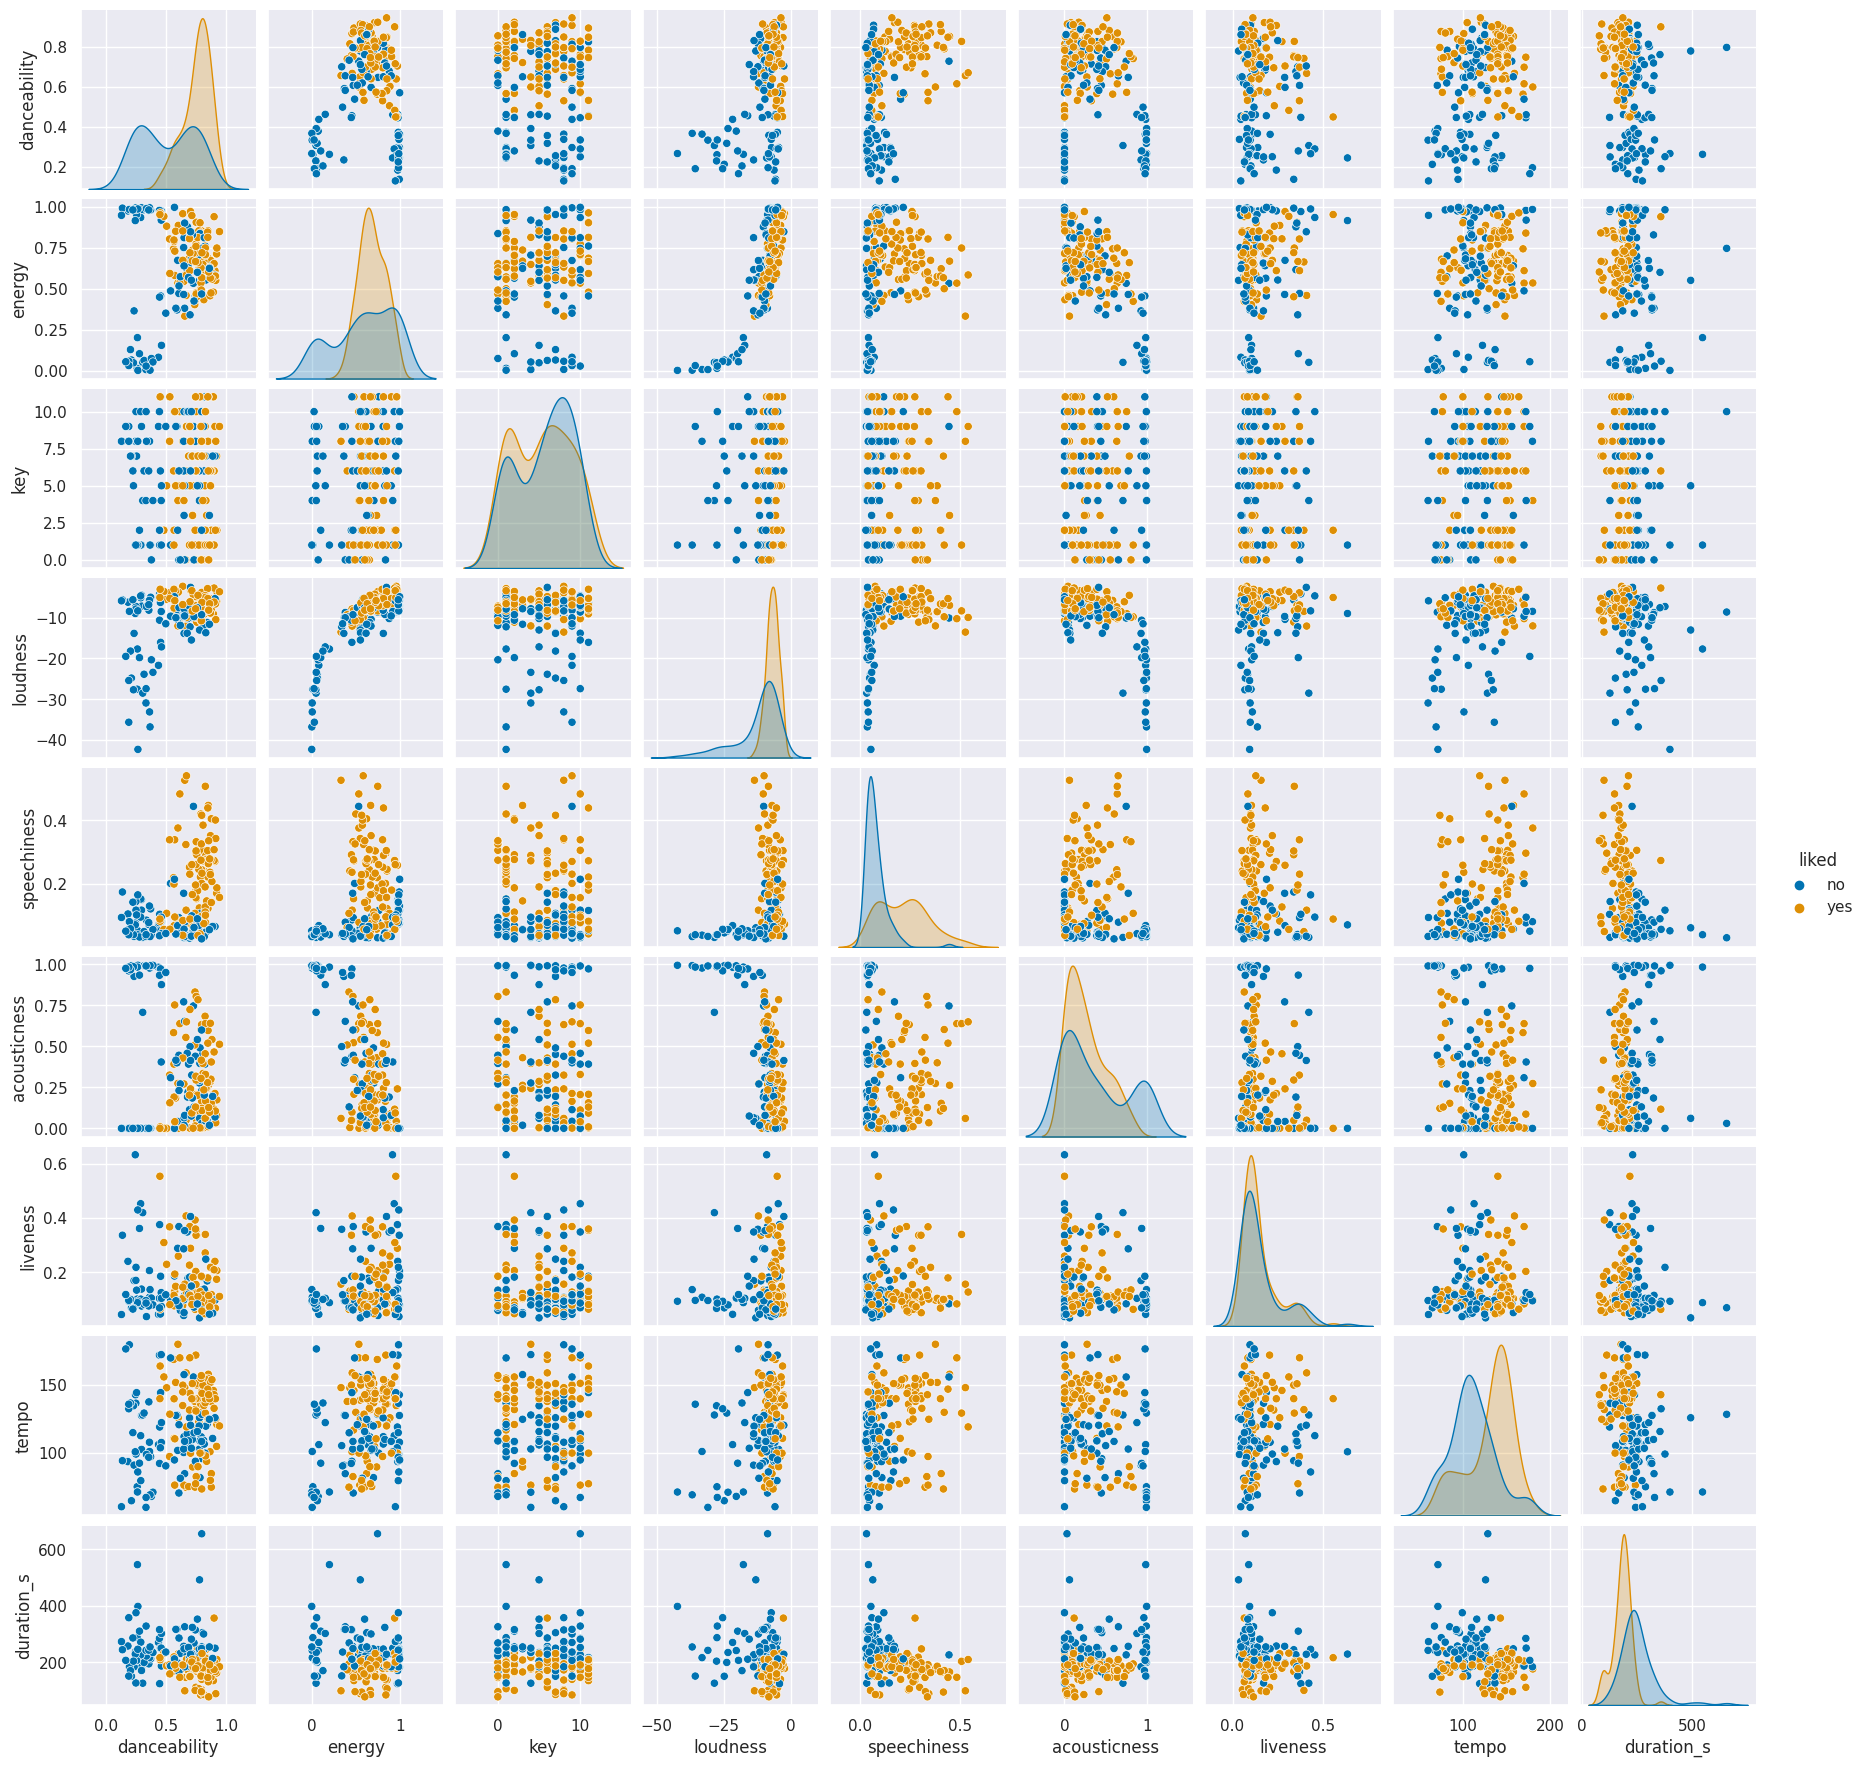

In [ ]:
sns.set() #creating a scatterplot matrix
sns.pairplot(df, vars = ["danceability", "energy", "key", "loudness",
             "speechiness", "acousticness", "liveness", "tempo",
             "duration_s"],  hue= 'liked', height=2, palette="colorblind")

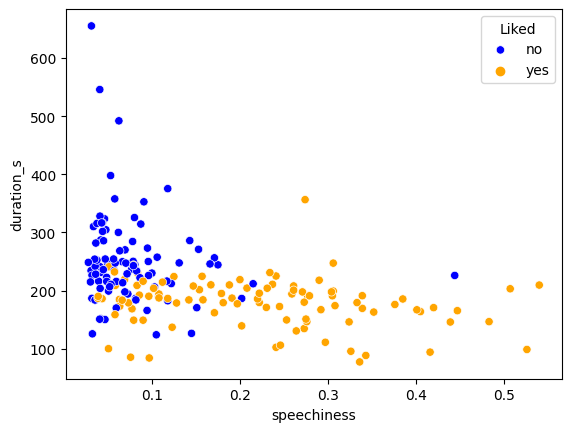

In [ ]:
my_palette = {'yes': 'orange', 'no': 'blue'}
sns.scatterplot(data=df, x="speechiness", y="duration_s", hue="liked", hue_order=['yes', 'no'], palette=my_palette)
plt.legend(title='Liked', loc='upper right', labels=['no', 'yes'])
plt.show()

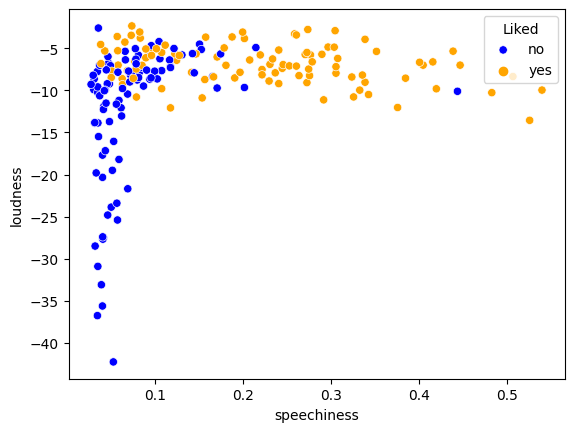

In [ ]:
sns.scatterplot(data=df, x="speechiness", y="loudness", hue="liked", hue_order=['yes', 'no'], palette=colors)
plt.legend(title='Liked', loc='upper right', labels=['no', 'yes'])
plt.show()

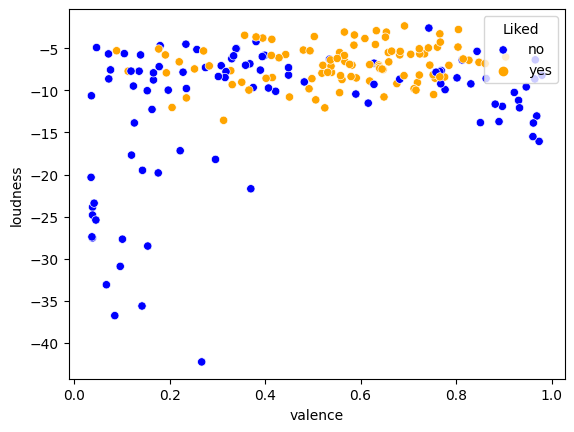

In [ ]:
sns.scatterplot(data=df, x="valence", y="loudness", hue="liked", hue_order=['yes', 'no'], palette=colors)
plt.legend(title='Liked', loc='upper right', labels=['no', 'yes'])
plt.show()

There are a large number of insights to be made from looking at these plots, such as the user taking a liking to songs that are short and high in spoken word content. For the most part, these graphs allow us to draw a number of insights from continuous variables such as duration, speechiness, loudness, etc., and less from categorical variables. The most telling variables appear to be speechiness, tempo, and valence, as they all have relatively distinguishable clusters of points that correspond to characteristics of songs the user liked and didn't like.

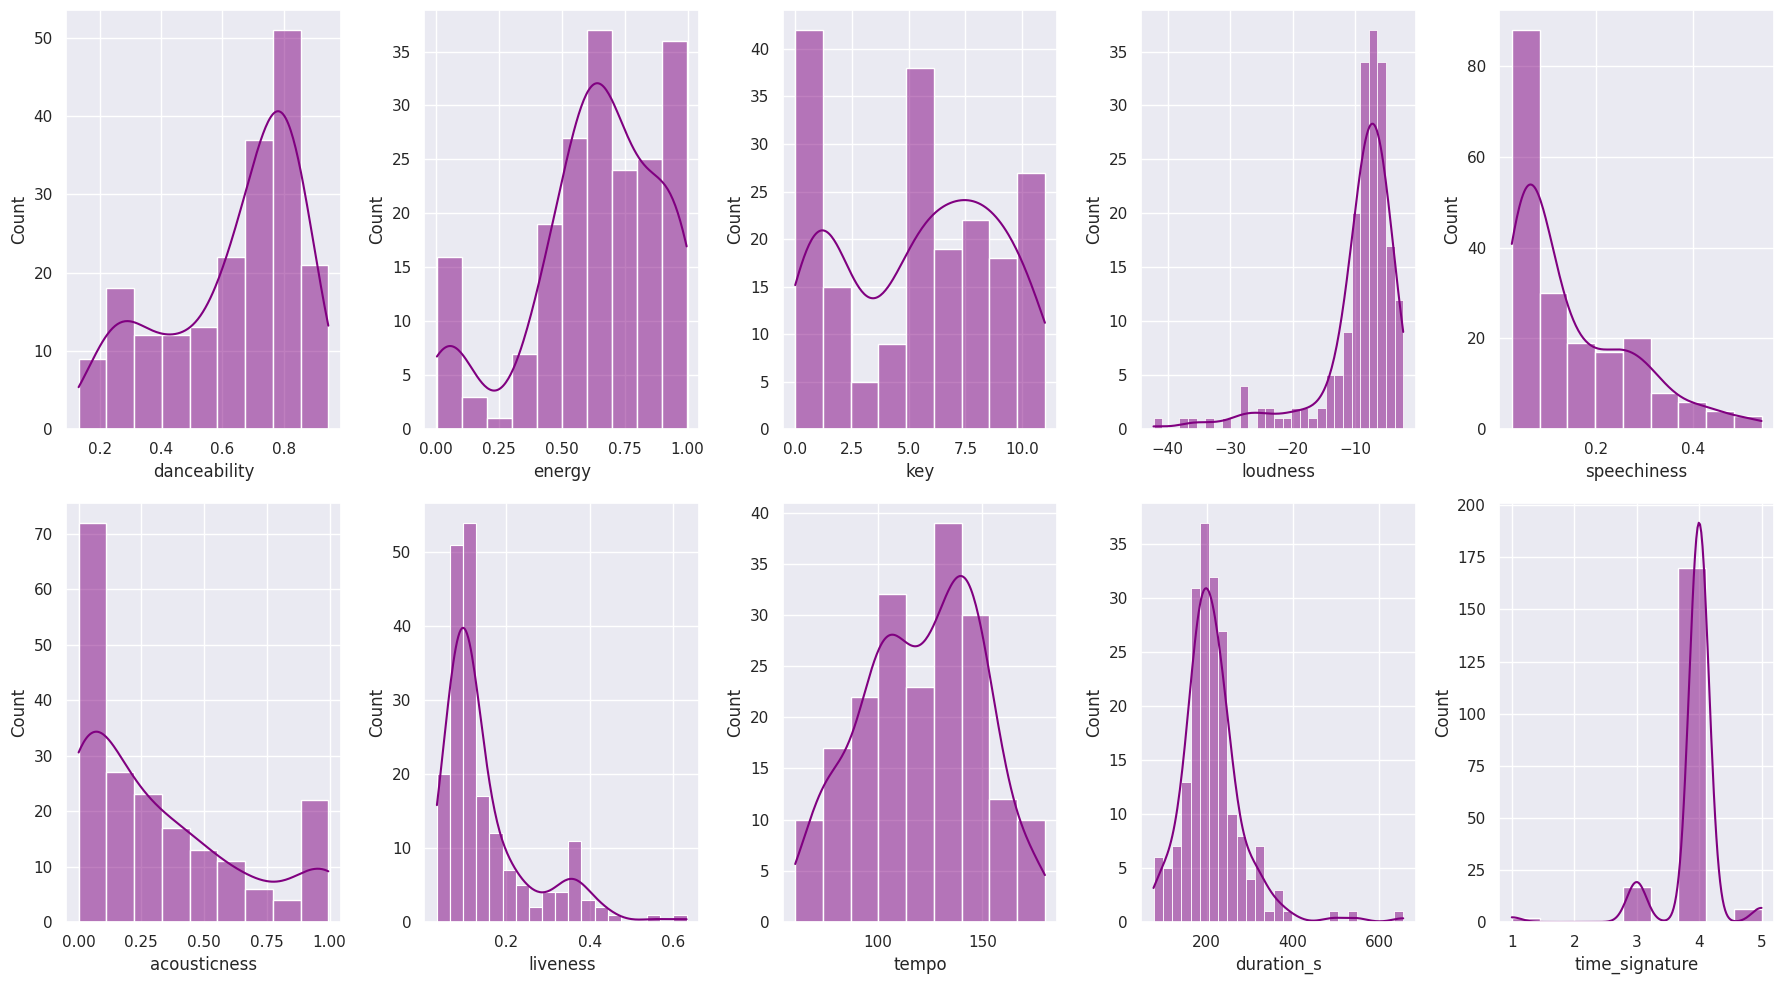

In [ ]:
#histogram of dataset
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 5, figsize=(18, 10))
variables = ["danceability", "energy", "key", "loudness",
             "speechiness", "acousticness", "liveness", "tempo",
             "duration_s", "time_signature"]

for i, var in enumerate(variables):
    row = i // 5
    col = i % 5
    sns.histplot(data=df, x=var, kde=True, ax=axs[row, col], color='purple')

plt.tight_layout()
plt.show()

Data for tempo and key are somewhat evenly distributed, while the other numerically-valued variables have some sort of skew in their distribution. For instance, the user apparently listens to songs with a low amount of acousticness and liveness for the most part.

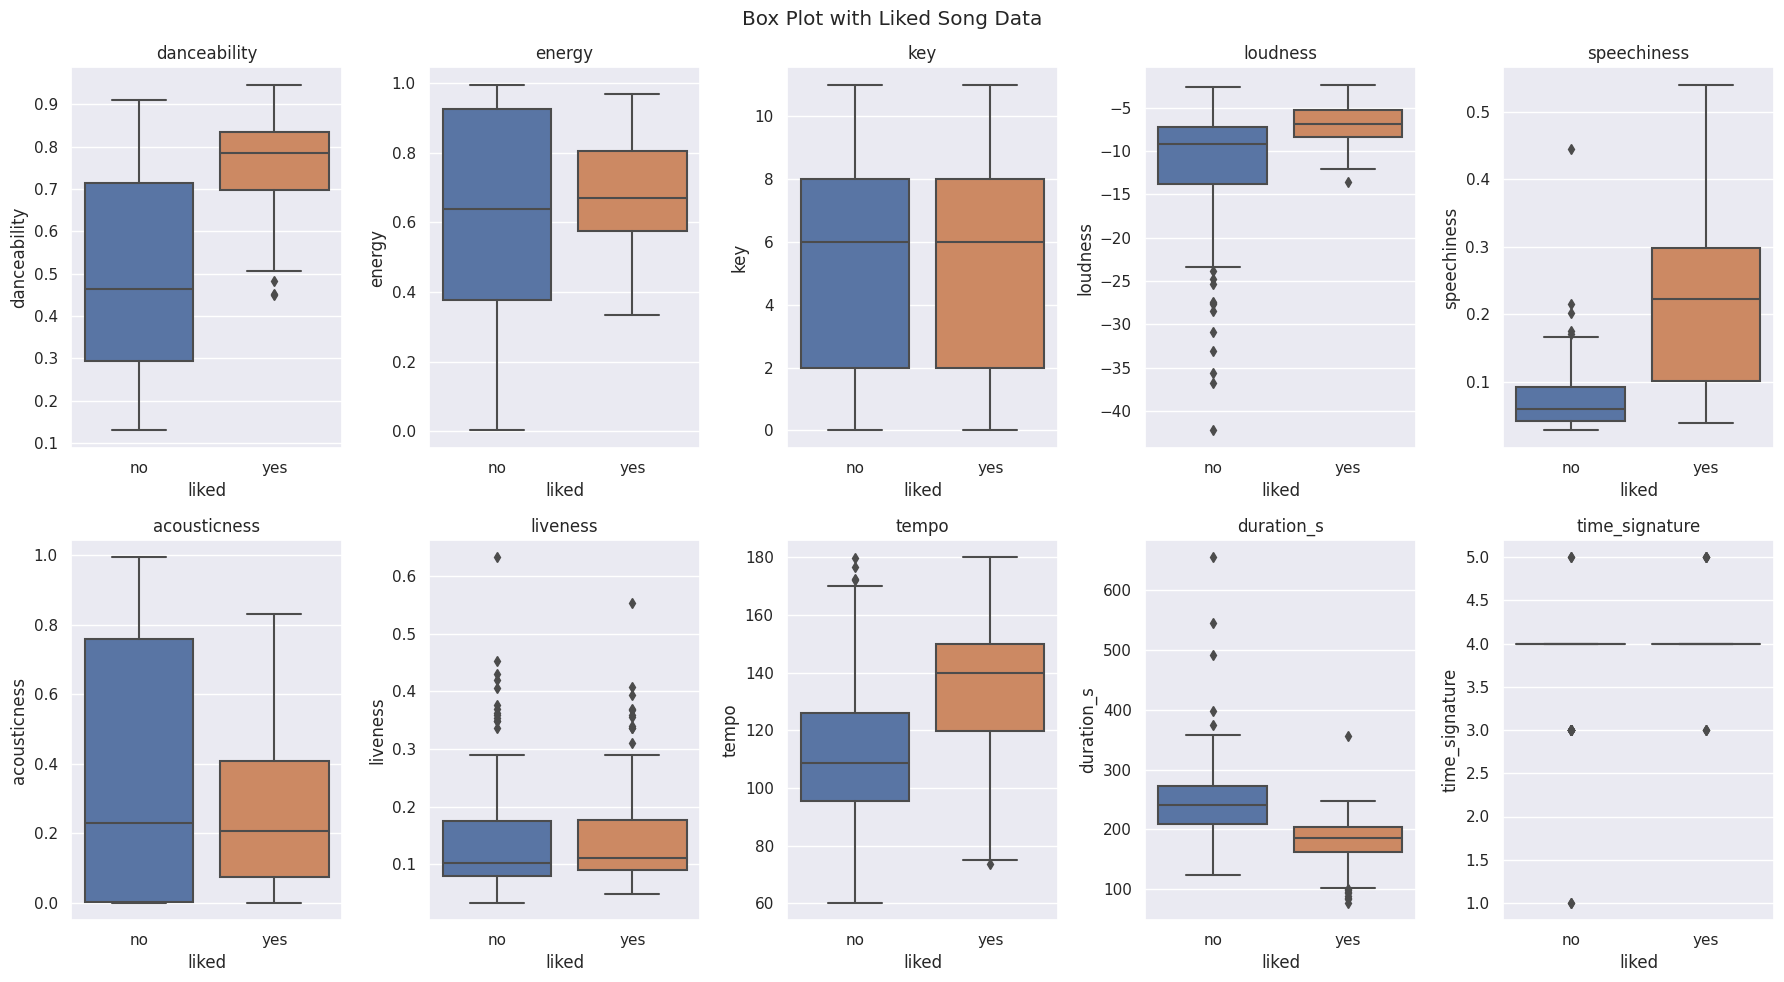

In [ ]:
#Boxplot Matrix
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
fig.suptitle('Box Plot with Liked Song Data') # Title of the graph

for i, ax_row in enumerate(axes):
    for j, ax_col in enumerate(ax_row):
        idx = i * 5 + j
        if idx >= len(variables):
            break
        sns.boxplot(ax=ax_col, data=df, x='liked', y=variables[idx])
        ax_col.set_title(variables[idx])

fig.tight_layout()

From the boxplots we can tell that the key the song is in does not effect the the user's preference for or against the songs. The plots are identical therefore showing there is no key that is favored. We can say the same about the liveness of the music. The songs that are live seem to be liked and disliked at the same rate. The boxplots for time signature also give us very little information based on their identical distributions. The most informative plots are the ones for danceability and speechiness, which clearly show a preference for songs that are danceable, and an aversion to songs that are not very speechy.


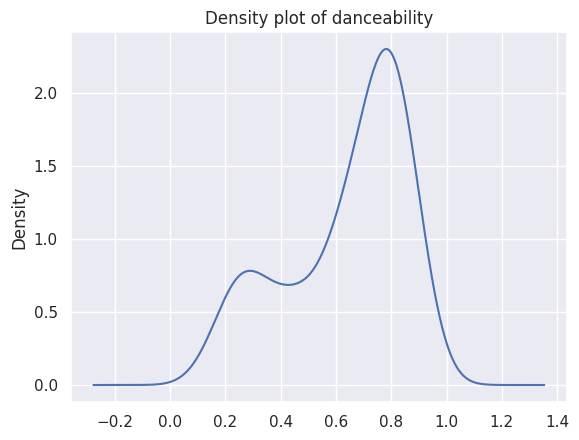

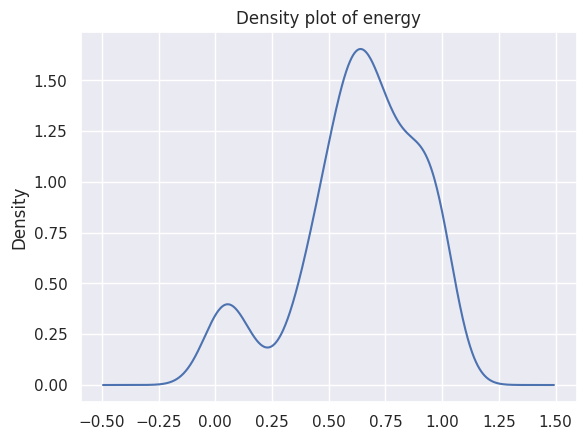

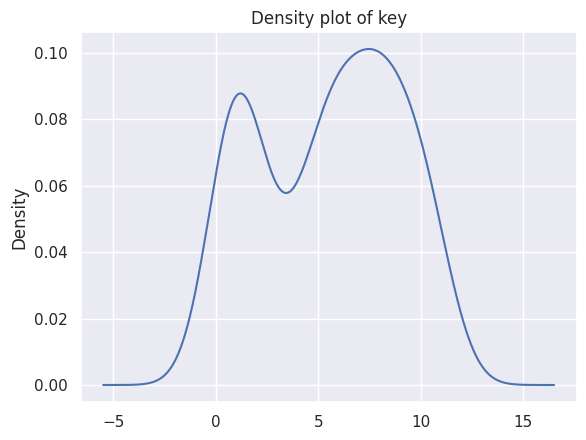

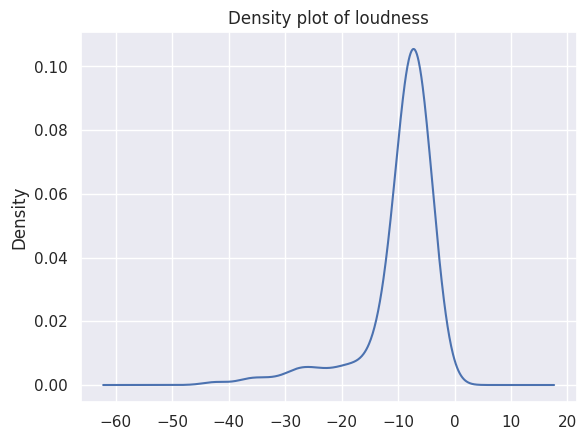

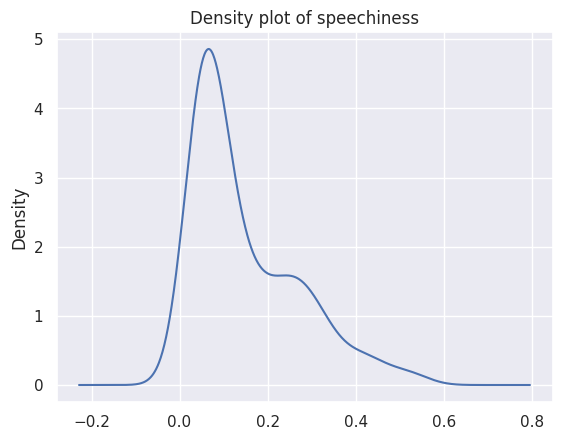

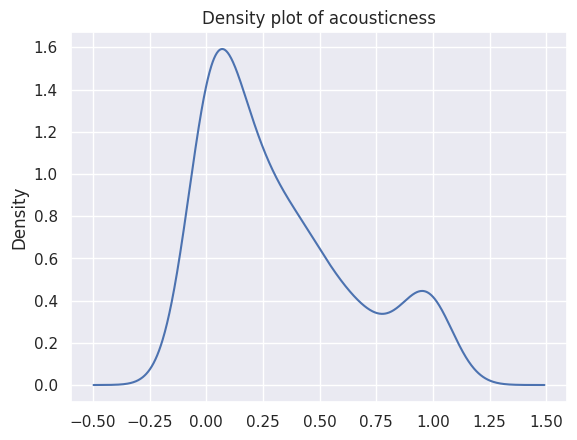

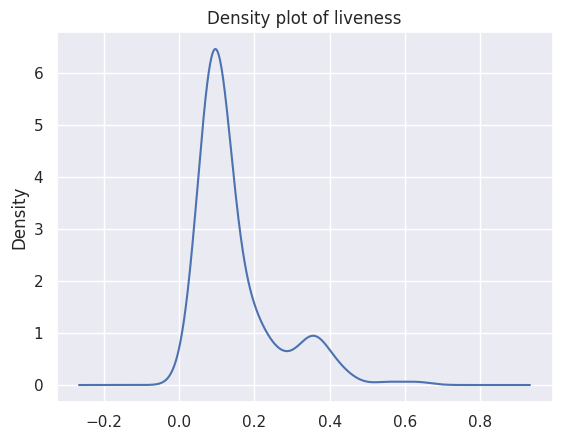

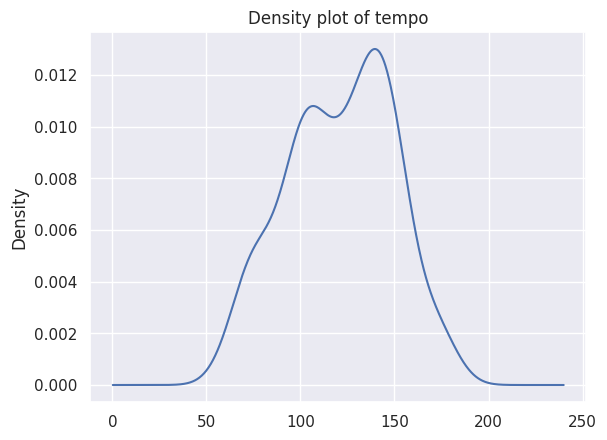

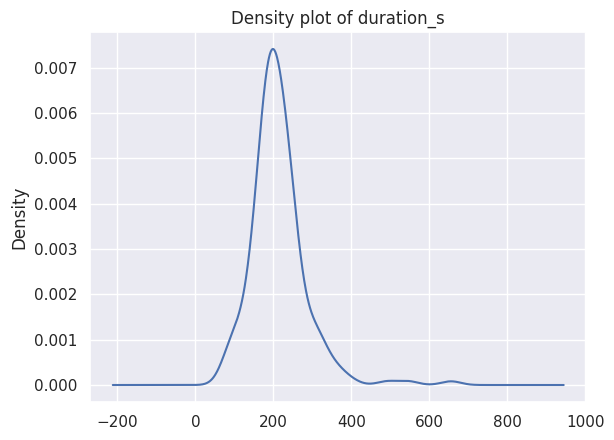

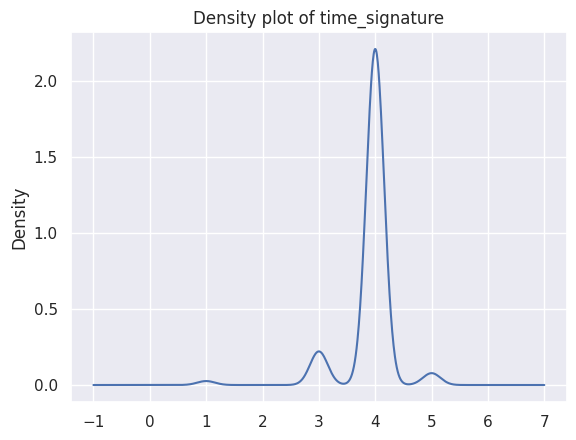

In [ ]:
for col in variables: #plotting densities of all variables
    df[col].plot.kde()
    plt.title(f"Density plot of {col}")
    plt.show()

#**Build Models:**

In [ ]:
features = df.drop('liked', axis=1) #setting feature and target variables
target = df.liked

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True, random_state=42) #splitting the data between testing and training

**DECISION TREE MODEL**

In [ ]:
accuracies = {} #creating a dictionary for the various training and testing accuracies and node counts
for model_complexity, parameter in [('Low-complexity', 2), ('Medium-complexity', 4), ('High-complexity', None)]: #creating three separate trees with varying
  dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth = parameter)                                #complexities and finding their accuracies
  dtree.fit(X_train, y_train)
  pred_train = dtree.predict(X_train)
  pred_test = dtree.predict(X_test)
  accuracies[model_complexity] = [accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test), dtree.tree_.node_count - 1]

accs = pd.DataFrame(accuracies, index=['Training accuracy', 'Test accuracy', 'Comparisons made']) #making a dataframe out of the accuracies to make them easy to visualize
accs

,Low-complexity,Medium-complexity,High-complexity
Training accuracy,0.846154,0.967949,1.000000
Test accuracy,0.820513,0.794872,0.846154
Comparisons made,6.000000,20.000000,26.000000


It seems that the High Complexity model is overfitting. The training accuracy is 100%, which indicates memorization hence why it is overfitting. Cross validation can help with overfitting of data. Cross validation splits data multiple times and it helps to get a better measure of the performance of the model.

In [ ]:
def model_metrics(y_true, y_predict): #function to report various model performance metrics
  accuracy= accuracy_score(y_true, y_predict)
  precision=precision_score(y_true, y_predict, pos_label='yes')
  recall=recall_score(y_true, y_predict, pos_label='yes')
  f1=f1_score(y_true, y_predict, pos_label='yes')
  balanced_accuracy=balanced_accuracy_score(y_true, y_predict)
  return [accuracy, precision, recall, f1, balanced_accuracy]

In [ ]:
def model_metrics_conf(y_true, y_predict, x_shape): #same as above but including confidence intervals
  accuracy= accuracy_score(y_true, y_predict)
  precision=precision_score(y_true, y_predict, pos_label='yes')
  recall=recall_score(y_true, y_predict, pos_label='yes')
  f1=f1_score(y_true, y_predict, pos_label='yes')
  balanced_accuracy=balanced_accuracy_score(y_true, y_predict)
  return [(i, classification_confint(i, x_shape)[0], classification_confint(i, x_shape)[1]) for i in [accuracy, precision, recall, f1, balanced_accuracy]]

In [ ]:
def classification_confint(acc, n): #function to generate confidence intervals
    '''
    Compute the 95% confidence interval for a classification problem.
      acc -- classification accuracy
      n   -- number of observations used to compute the accuracy
    Returns a tuple (lb,ub)
    '''
    import math
    interval = 1.96*math.sqrt(acc*(1-acc)/n)
    lb = max(0, acc - interval)
    ub = min(1.0, acc + interval)
    return (lb,ub)

In [ ]:
all_metrics_values = {} #creating a dictionary containing metrics for low, medium, and high complexity decision tree models
for model_complexity, parameter in [('Low-complexity', 2), ('Medium-complexity', 4), ('High-complexity', None)]: #creating three separate trees with varying complexities and finding their accuracies
  dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth = parameter)
  dtree.fit(X_train, y_train)
  pred_train = dtree.predict(X_train)
  pred_test = dtree.predict(X_test)
  all_metrics_values[model_complexity] = pd.DataFrame(data = [model_metrics(y_train, pred_train), model_metrics(y_test, pred_test)], columns = ['accuracy', 'precision', 'recall', 'f1', 'balanced accuracy'], index=['Train', 'Test'])

for key in all_metrics_values:
  print('\n' + key + '\n')
  print(all_metrics_values[key])


Low-complexity

       accuracy  precision  recall        f1  balanced accuracy
Train  0.846154   0.850000    0.85  0.850000           0.846053
Test   0.820513   0.842105    0.80  0.820513           0.821053

Medium-complexity

       accuracy  precision  recall        f1  balanced accuracy
Train  0.967949   1.000000  0.9375  0.967742           0.968750
Test   0.794872   0.833333  0.7500  0.789474           0.796053

High-complexity

       accuracy  precision  recall        f1  balanced accuracy
Train  1.000000   1.000000     1.0  1.000000           1.000000
Test   0.820513   0.842105     0.8  0.820513           0.821053


In [ ]:
def plot_bar_results(dataset_type, all_metrics_values): # function to plot the metrics for the various decision trees
    fig = go.Figure()
    for model_name, metrics_df in all_metrics_values.items():
        metrics_names = list(metrics_df.columns)
        values = metrics_df.loc[dataset_type].to_numpy()
        fig.add_trace(go.Bar(y=values, x=metrics_names, name=model_name))
    fig.update_layout(barmode="group", xaxis_tickangle=0, title_text=dataset_type+" Dataset")
    fig.show()

In [ ]:
plot_bar_results("Train", all_metrics_values)

In [ ]:
plot_bar_results("Test", all_metrics_values)

##**Perform A Model Search:**

In [ ]:
model = KNeighborsClassifier() #creating a K-nearest neighbors model

cv = KFold(n_splits=5, shuffle=True) #shuffling the data set and doing 5-fold cross validation

param_grid = {
    'n_neighbors': list(range(1,10))
}

grid = GridSearchCV(model, param_grid, cv=cv) #searching for best parameters

grid.fit(X_train, y_train) #fitting model to data
print('########## KNN Performance ##########')
print('Best parameters:') #returning the best parameters
for parameter, value in list(zip(grid.best_params_.keys(), grid.best_params_.values())):
  print('{}: {}'.format(parameter, value))

scores = cross_val_score(model, X_train, y_train ,cv=cv)

print("Fold Accuracies: {}".format(scores))
knn_mean_score=scores.mean()
print(f'Mean accuracy: {knn_mean_score}')

########## KNN Performance ##########
Best parameters:
n_neighbors: 5
Fold Accuracies: [0.81 0.77 0.74 0.65 0.68]
Mean accuracy: 0.730241935483871


We have performed cross validation because cross validation splits data multiple times and it helps to get a better measure of the performance of the model. It is also an integral part of overfitting prevention.
<br>
The cross validation scores of the best model are : 0.81, 0.77, 0.74, 0.65, 0.68
<br>
The mean accuracy of the best model is 73.0%.

#**Model Evaluation:**

In [ ]:
model = KNeighborsClassifier() #creating a K-nearest neighbors model

cv = KFold(n_splits=5, shuffle=True) #shuffling the data set and doing 5-fold cross validation

param_grid = {
    'n_neighbors': list(range(1,10))
}

grid = GridSearchCV(model, param_grid, cv=cv) #searching for best parameters

grid.fit(X_train, y_train) #fitting model to data
print('########## KNN Performance ##########')
print('Best parameters:') #returning the best parameters
for parameter, value in list(zip(grid.best_params_.keys(), grid.best_params_.values())):
  print('{}: {}'.format(parameter, value))


pred_test = grid.best_estimator_.predict(X_test) #getting accuracy and balanced accuracy with confidence intervals for both
pd.DataFrame(data = [list(i) for i in model_metrics_conf(y_test, pred_test, X_test.shape[0])], columns=['actual', 'lower bound', 'upper bound'], index=['accuracy', 'precision', 'recall', 'f1', 'balanced accuracy'])

########## KNN Performance ##########
Best parameters:
n_neighbors: 9


,actual,lower bound,upper bound
accuracy,0.923077,0.839445,1.000000
precision,0.947368,0.877286,1.000000
recall,0.900000,0.805845,0.994155
f1,0.923077,0.839445,1.000000
balanced accuracy,0.923684,0.840356,1.000000


In [ ]:
targets = list(target.unique()) #creating a confusion matrix for KNN model
cm = confusion_matrix(y_true= y_test,y_pred= pred_test, labels=targets)
cm_df = pd.DataFrame(cm, index=targets, columns=targets)
print("KNN Confusion Matrix:\n{}".format(cm_df))

KNN Confusion Matrix:
     no  yes
no   18    1
yes   2   18


In [ ]:
model2 = DecisionTreeClassifier() #creating a DT model

param_grid2 = {
    'max_depth': list(range(1,20)) + [None],
    'criterion': ['entropy', 'gini']
}

grid2 = GridSearchCV(model2, param_grid2, cv=cv) #searching for best parameters

grid2.fit(X_train, y_train) #fitting the model
print('########## Decision Tree Performance ##########')
print('Best parameters:') #returning the best parameters
for parameter, value in list(zip(grid2.best_params_.keys(), grid2.best_params_.values())):
  print('{}: {}'.format(parameter, value))

pred_test2 = grid2.best_estimator_.predict(X_test) #getting accuracy and balanced accuracy plus confidence intervals for both
pd.DataFrame(data = [list(i) for i in model_metrics_conf(y_test, pred_test2, X_test.shape[0])], columns=['actual', 'lower bound', 'upper bound'], index=['accuracy', 'precision', 'recall', 'f1', 'balanced accuracy'])

########## Decision Tree Performance ##########
Best parameters:
criterion: entropy
max_depth: 18


,actual,lower bound,upper bound
accuracy,0.820513,0.700069,0.940956
precision,0.842105,0.727662,0.956549
recall,0.800000,0.674460,0.925540
f1,0.820513,0.700069,0.940956
balanced accuracy,0.821053,0.700751,0.941354


In [ ]:
cm2 = confusion_matrix(y_true= y_test,y_pred= pred_test2, labels=targets) #creating a confusion matrix for the decision tree model
cm_df = pd.DataFrame(cm2, index=targets, columns=targets)
print("Decision Tree Confusion Matrix:\n{}".format(cm_df))

Decision Tree Confusion Matrix:
     no  yes
no   16    3
yes   4   16


In [ ]:
model3 = LogisticRegression() #creating a logistic regression model

param_grid3 = {
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'max_iter': list(range(50, 76))
}

grid3 = GridSearchCV(model3, param_grid3, cv=cv) #searching for best parameters

grid3.fit(X_train, y_train) #fitting the model
print('########## Logistic Regression Performance ##########')
print('Best parameters:') #returning the best parameters
for parameter, value in list(zip(grid3.best_params_.keys(), grid3.best_params_.values())):
  print('{}: {}'.format(parameter, value))

pred_test3 = grid3.best_estimator_.predict(X_test) #getting accuracy and balanced accuracy plus confidence intervals for both
pd.DataFrame(data = [list(i) for i in model_metrics_conf(y_test, pred_test3, X_test.shape[0])], columns=['actual', 'lower bound', 'upper bound'], index=['accuracy', 'precision', 'recall', 'f1', 'balanced accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

########## Logistic Regression Performance ##########
Best parameters:
max_iter: 50
solver: newton-cg


,actual,lower bound,upper bound
accuracy,0.846154,0.732916,0.959392
precision,0.888889,0.790255,0.987523
recall,0.800000,0.674460,0.925540
f1,0.842105,0.727662,0.956549
balanced accuracy,0.847368,0.734497,0.960239


In [ ]:
cm3 = confusion_matrix(y_true= y_test,y_pred= pred_test3, labels=targets) #confusion matrix for logistic regression model
cm_df = pd.DataFrame(cm3, index=targets, columns=targets)
print("Logistic Regression Confusion Matrix:\n{}".format(cm_df))

Logistic RegressionConfusion Matrix:
     no  yes
no   17    2
yes   4   16


In [ ]:
model4 = MLPClassifier(max_iter=10000, random_state=1)  #performing grid search to find the best parameters for a two-layer MLP classifier model

param_grid4 = {
    'hidden_layer_sizes':
      [
      (26,26), (26,52), (26,104), (26), (52), (104)
      ],
    'activation' : ['logistic', 'relu']
}

grid4 = GridSearchCV(model4, param_grid4, cv=cv) #searching for best parameters
grid4.fit(X_train, y_train)
print('########## MLP Performance ##########')
print('Best parameters:') #returning the best parameters
for parameter, value in list(zip(grid4.best_params_.keys(), grid4.best_params_.values())):
  print('{}: {}'.format(parameter, value))

pred_test4 = grid4.best_estimator_.predict(X_test)
pd.DataFrame(data = [list(i) for i in model_metrics_conf(y_test, pred_test4, X_test.shape[0])], columns=['actual', 'lower bound', 'upper bound'], index=['accuracy', 'precision', 'recall', 'f1', 'balanced accuracy'])

########## MLP Performance ##########
Best parameters:
activation: relu
hidden_layer_sizes: 52


,actual,lower bound,upper bound
accuracy,0.871795,0.766869,0.976721
precision,0.894737,0.798418,0.991055
recall,0.850000,0.737933,0.962067
f1,0.871795,0.766869,0.976721
balanced accuracy,0.872368,0.767643,0.977094


In [ ]:
cm4 = confusion_matrix(y_true= y_test,y_pred= pred_test4, labels=targets) #confusion matrix for logistic regression model
cm_df = pd.DataFrame(cm4, index=targets, columns=targets)
print("MLP Confusion Matrix:\n{}".format(cm_df))

MLP Confusion Matrix:
     no  yes
no   17    2
yes   3   17


In [ ]:
model5 = SVC(max_iter=10000)

param_grid5 = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf', 'sigmoid']},
  {'C': [1,10,100,1000], 'gamma': [0.001, 0.0001], 'degree': list(range(4)), 'kernel': ['poly']},
 ]

grid5 = GridSearchCV(model5, param_grid5, cv=5)
grid5.fit(X_train, y_train)
print('########## SVM Performance ##########')
print('Best parameters:') #returning the best parameters
for parameter, value in list(zip(grid5.best_params_.keys(), grid5.best_params_.values())):
  print('{}: {}'.format(parameter, value))

pred_test5 = grid5.best_estimator_.predict(X_test)
pd.DataFrame(data = [list(i) for i in model_metrics_conf(y_test, pred_test5, X_test.shape[0])], columns=['actual', 'lower bound', 'upper bound'], index=['accuracy', 'precision', 'recall', 'f1', 'balanced accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Con

########## SVM Performance ##########
Best parameters:
C: 1000
degree: 2
gamma: 0.0001
kernel: poly


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,actual,lower bound,upper bound
accuracy,0.820513,0.700069,0.940956
precision,0.882353,0.781233,0.983473
recall,0.750000,0.614098,0.885902
f1,0.810811,0.687888,0.933733
balanced accuracy,0.822368,0.702414,0.942323


In [ ]:
cm5 = confusion_matrix(y_true= y_test,y_pred= pred_test5, labels=targets) #confusion matrix for logistic regression model
cm_df = pd.DataFrame(cm5, index=targets, columns=targets)
print("SVC Confusion Matrix:\n{}".format(cm_df))

SVC Confusion Matrix:
     no  yes
no   17    2
yes   5   15


Of all of the models above, the decision tree produces the most false negatives. It had three instances of predicting negative (or disliked) when the actual values were positive (or liked). In the case of predicting weither or not a song is liked this is not harmful, but in some cases it can be. In the instance that there is a false negative in a disease daignosis there can be deadly consequences. A patient who has the disease that was undetected by a false negative may not receive the appropriate treatment, possibly leading to their death.

#**Best and Second Best Model:**

The best model for this dataset was the KNN classifier, with an accuracy of roughly 92%, and only one reported false negative. The second best model was the multi-layer perceptron with roughly 87% accuracy and two false negatives. The difference between the two models is not statistically significant, and therefore there is no clear choice as to which to use, due to the confidence intervals overlapping. The confidence interval for the MLP was: accuracy: 87.1795,	CI: (76.6869,	97.6721). The confidence interval for the KNN classifier was: accuracy:	92.3077,	CI: (83.9445	100.0000).